# Project 22 - Classifying Heart Disease

In this project we'll be using a real-life dataset: [the Heart Disease Data Set](https://archive.ics.uci.edu/dataset/45/heart+disease) from the UCI Machine Learning Repository. This dataset comes from the famous Cleveland Clinic Foundation, which recorded information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual. The data has been cleaned so that we can perform binary classification in this project.

<b>The goal of this project is to create a Logistic Regression Model, that accurately classifies heart diseases.</b>

## Reading in the Data

In [1]:
import pandas as pd
heart = pd.read_csv('heart_disease.csv', index_col=0)
print(heart.shape)
heart.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


Our dataset has 303 rows and 14 columns. The following table contains information about each column:
| Column | Description |
|-------|--------------|
| age| age of the observation |
|sex | sex of the observation (1: male, 0:female)|
|cp | chest pain type (1: typical angina, 2. atypical angina, 3. non-anginal pain, 4. asymptomatic) |
|trestbps| resting blood pressure (mm Hg)|
|chol | serum cholestoral in mg/dl |
|fbs | fasting blood sugar (1 if over 120mg/dl, else 0) |
|restecg | resting electocardiographic results |
|thalach | maximum heart rate achieved |
|exang | exercise induced angina |
|oldpeak | ST depression induced by exercise relative to rest |
|slope | the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping) |
|ca| number of major vessels (0-3) colored by flourosopy |
|thal| 3 = normal, 6 = fixed defect, 7 = reversable defect |
|present| whether or not the observation has a heart disease (1 = yes, 0 = no) |

In [2]:
heart.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca           object
thal         object
present       int64
dtype: object

All of the columns have numerical values, so there is no need to create dummy variables. However, `ca` and `thal` are objects, so let's change them to floats. Let's then check some relationships between the potential predictor variables with the outcome (`present`).

In [3]:
print(heart['ca'].unique())
print(heart['ca'].value_counts())
print(heart['thal'].unique())
print(heart['thal'].value_counts())

['0.0' '3.0' '2.0' '1.0' '?']
ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64
['6.0' '3.0' '7.0' '?']
thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64


We can see that there are 4 `ca` values with `?` value. We will drop all of these, because 4 rows missing is around 1 percent of our data, but having wrong values could affect the end result badly (if we assigned the mean value for each observation, it would have be either 1.0 or 2.0, which could be completely wrong). Same goes for `thal`, there are only 2 `?` values, so we will remove those observations.

In [4]:
heart = heart[heart['ca'] != '?']
heart = heart[heart['thal'] != '?']
#changing to float
heart['ca'] = heart['ca'].astype('float')
heart['thal'] = heart['thal'].astype('float')

print(heart['ca'].value_counts())
print(heart['thal'].value_counts())

ca
0.0    174
1.0     65
2.0     38
3.0     20
Name: count, dtype: int64
thal
3.0    164
7.0    115
6.0     18
Name: count, dtype: int64


## Plotting

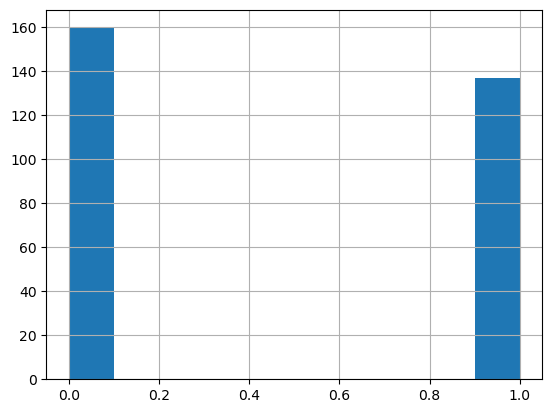

In [5]:
import matplotlib.pyplot as plt
heart['present'].hist()
plt.show()

From the histogram above we can see that there are around 160 observations with no heart disease and 138 observations with a heart disease. This means that the amount of observations is almost equal. Let's now check the differences for each column's mean value when grouped by heart disease values.

In [6]:
# Checking potential predictors
grouped_data = heart.groupby("present").agg(
    {
        "age": "mean",
        "sex": "mean",
        "cp": "mean",
        "trestbps": "mean",
        "chol": "mean",
        "fbs": "mean",
        "restecg": "mean",
        "thalach": "mean",
        "exang": "mean",
        "oldpeak": "mean",
        "slope": "mean",
        "ca": "mean",
        "thal": "mean"
    }
)
grouped_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.643750,0.556250,2.793750,129.175000,243.493750,0.143750,0.843750,158.581250,0.143750,0.598750,1.412500,0.275000,3.787500
1,56.759124,0.817518,3.583942,134.635036,251.854015,0.145985,1.175182,139.109489,0.540146,1.589051,1.824818,1.145985,5.832117


Some columns have a small, but noticeable difference when stratified by predictors. Based on the differences and some knowledge about heart disease, these seem like good candidates for predictors:
- `age`
- `thalach` (maximum heart rate achieved)
- `restecg` (resting ECG)
- `ca` (number of vessels colored by fluoroscopy)

## Dividing the Data

Next we need to divide our dataset to a training set that will be used to estimate the regression coefficients and to a test set that will be used to assess the predictive ability of the model. We will be using 30% for testing and 70% for training.

The outcome y will be the `present` column, and the training data will be the four variables mentioned above.

In [7]:
from sklearn.model_selection import train_test_split

X = heart[['age', 'thalach', 'restecg', 'ca']]
y = heart['present']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(207, 4)
(90, 4)
(207,)
(90,)
present
0    109
1     98
Name: count, dtype: int64
present
0    51
1    39
Name: count, dtype: int64


Our training data has 207 observations and our testing data has 90 observations. Both training and testing sets have `0` and `1` values fairly close to each other meaning that they are well divided (if this wasn't the case, we could change the random_state until we get a good distribution).

## Building the Model

Now we are ready to build the classification model and do some initial assessments. We will check how accurate our model is and whether it performs better on cases or non-cases.

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_train, y_train)
accuracy

0.7681159420289855

Our model has an accuracy of 0.77, which is fairly good. We are now going to calculate the sensitivity using the following formula:

<i>Sensitivity = True Positives / (True Positives + False Negatives)</i>

We are also going to calculate the specificity using the following formula:

<i>Specificity = True Negatives / (True Negatives + False Positives)</i>

- True negative means that the model predicts 0 when the correct outcome is 0.
- True positive means that the model predicts 1 when the correct outcome is 1.
- False negative means that the model predicts 0 when the correct outcome is 1.
- False positive means that the model predicts 1 when the correct outcome is 0.

In [9]:
predictions = model.predict(X_train)
tn = sum((y_train == 0) & (predictions == 0))
tp = sum((y_train == 1) & (predictions == 1))
fn = sum((y_train == 1) & (predictions == 0))
fp = sum((y_train == 0) & (predictions == 1))

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print(f"Sensitivity is: {sensitivity}\nSpecificity is: {specificity}")

Sensitivity is: 0.6632653061224489
Specificity is: 0.8623853211009175


We can see that the model's sensitivity is 66.3%, specificity is 86.2% and accuracy is 76.8%. This means that the model performs better on true negatives than on true positives, meaning that it predicts values `0` (no heart disease) better than `1` (heart disease).

## Interpreting the Model Coefficients

Now we are going to look at the coefficients to see if they make sense, given the problem. Logistic regression relates the binary outcome to the linear combination of predictors via the following function:

$$\log\left(\frac{EY}{1-EY}\right) = \beta_0 + \beta_1 \mathbf{X} $$

Then we can use the log-odds ratio for a unit increase in a predictor:
$$\log\left(\frac{O_1}{O_0}\right) = \beta_1 $$

where O<sub>0</sub> represents the odds ratio when the predictor is 0, and O<sub>1</sub> represents the odds ratio when the predictor is 1. However, we're usually interested in examining these effects on the odds scale, so we take e to both sides to get the following:

$$ O_1 = e^{\beta_1} O_0 $$



In [10]:
coefs = ["age", "thalach", "restecg", "ca"]

for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(val, 2))

age : -0.02
thalach : -0.04
restecg : 0.39
ca : 1.18


In [11]:
import numpy as np
for coef, val in zip(coefs, model.coef_[0]):
    print(coef, ":", round(np.exp(val), 2))

age : 0.98
thalach : 0.96
restecg : 1.47
ca : 3.25


Interestingly higher age and maximum heart rate (`thalach`) are associated with lower odds of heart disease holding the other predictors constant (both of these are close to 1). Resting ECG and the number of colored vessels are associated with higher odds of heart disease holding the other predictors constant. Resting ECG has a 47% increase and colored vessels has a very high increase, 225%.

## Final Model Evaluation

Finally we are going to use the model to calculate test predictions and see how well it performs with our testing dataset. We are going to calculate accuracy, sensitivity and specifity again.

In [12]:
test_predictions = model.predict(X_test)
test_accuracy = model.score(X_test, y_test)
test_tn = sum((y_test == 0) & (test_predictions == 0))
test_tp = sum((y_test == 1) & (test_predictions == 1))
test_fn = sum((y_test == 1) & (test_predictions == 0))
test_fp = sum((y_test == 0) & (test_predictions == 1))

test_sensitivity = test_tp/(test_tp+test_fn)
test_specificity = test_tn/(test_tn+test_fp)

print(f"Accuracy is {test_accuracy}\nSensitivity is: {test_sensitivity}\nSpecificity is: {test_specificity}")

Accuracy is 0.7555555555555555
Sensitivity is: 0.7948717948717948
Specificity is: 0.7254901960784313


## Conclusions

Using test data, we got an accuracy of 76%, sensitivity of 79% and specificity of 73%. Compared to the training set, the accuracy is a little bit lower, but almost equal (76% vs. 77%). Sensitivity is much better (79% vs. 66%) and specificity is worse (73% vs 86%). This means that our model now performed better with cases and worse with non-cases.

Our model is far from perfect, and we could try different features and models to get higher scores. 76% accuracy is not bad and having higher sensitivity with our test data shows that this model could possibly be used in medical conditions, where it is more important to identify cases than non-cases.